In [ ]:
# Lab | Making predictions with logistic regression
# In this lab, you will be using the Sakila database of movie rentals.

# In order to optimize our inventory, we would like to know which films will be rented. 
# We are asked to create a model to predict it. So we use the information we have from May 2005 to create the model.


In [1]:
import pymysql
from sqlalchemy import create_engine, text
import pandas as pd
import getpass
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
password = getpass.getpass()

········


In [3]:
# 1. Create a query or queries to extract the information you think may be relevant for building the 
# prediction model. It should include some film features and some rental features (X).

connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''SELECT f.title, f.rating, f.rental_rate, f.length, c.name AS category 
FROM film f
JOIN film_category fc
ON f.film_id = fc.film_id
JOIN category c 
ON fc.category_id = c.category_id
ORDER BY f.film_id;'''

In [4]:
# 2. Create a query to get the list of all unique film titles and a boolean indicating if it was rented (rental_date) in May 2005. 
# (Create new column called - 'rented_in_may'). This will be our TARGET (y) variable.

query2 = '''SELECT DISTINCT f.title,
    CASE
    WHEN EXISTS (
        SELECT 1
        FROM inventory i
        JOIN rental r ON i.inventory_id = r.inventory_id
        WHERE f.film_id = i.film_id AND MONTH(r.rental_date) = 5) 
        THEN 'yes'
        ELSE 'no'
    END AS rented_in_may
FROM film f;'''

In [5]:
# 3. Read the data into a Pandas dataframe. At this point you should have 1000 rows. 
# Number of columns depends on the number of features you chose.

data_x = pd.read_sql_query(query, engine)
data_x.head()

,title,rating,rental_rate,length,category
0,ACADEMY DINOSAUR,PG,0.99,86,Documentary
1,ACE GOLDFINGER,G,4.99,48,Horror
2,ADAPTATION HOLES,NC-17,2.99,50,Documentary
3,AFFAIR PREJUDICE,G,2.99,117,Horror
4,AFRICAN EGG,G,2.99,130,Family


In [6]:
data_y = pd.read_sql_query(query2, engine)
data_y.head()

,title,rented_in_may
0,ACADEMY DINOSAUR,yes
1,ACE GOLDFINGER,no
2,ADAPTATION HOLES,yes
3,AFFAIR PREJUDICE,yes
4,AFRICAN EGG,yes


In [7]:
# 4. Analyze extracted features (X) and transform them. 
# You may need to encode some categorical variables, or scale numerical variables.

data_x.dtypes

title           object
rating          object
rental_rate    float64
length           int64
category        object
dtype: object

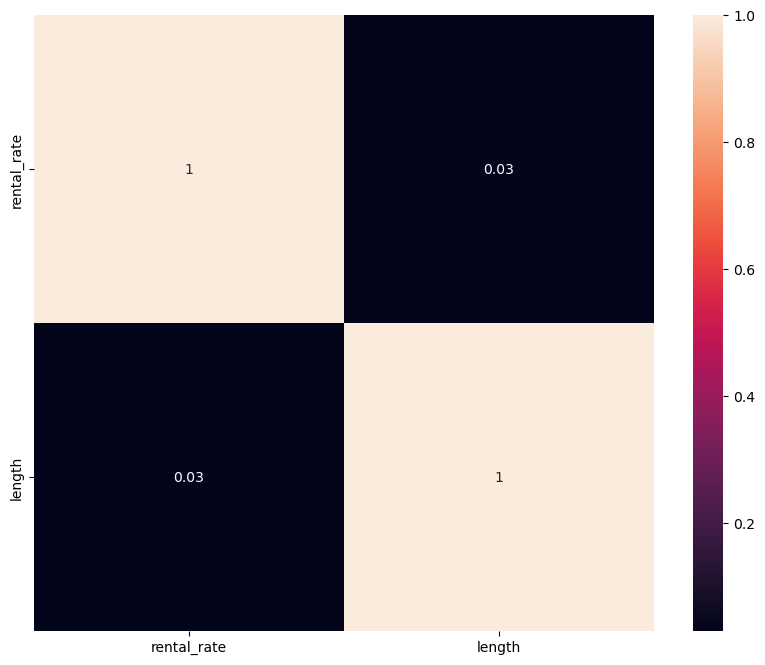

In [8]:
corr_matrix = data_x.select_dtypes(np.number).corr(method = 'pearson')  # no correlation
fig, ax = plt.subplots(figsize = (10, 8))
ax = sns.heatmap(corr_matrix, annot = True)
plt.show()

In [9]:
def plot_distributions(df):
    numerical_columns = df.select_dtypes(np.number)
    for col in numerical_columns:
        sns.displot(df[col])
        plt.show()

/Users/vschuckar/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


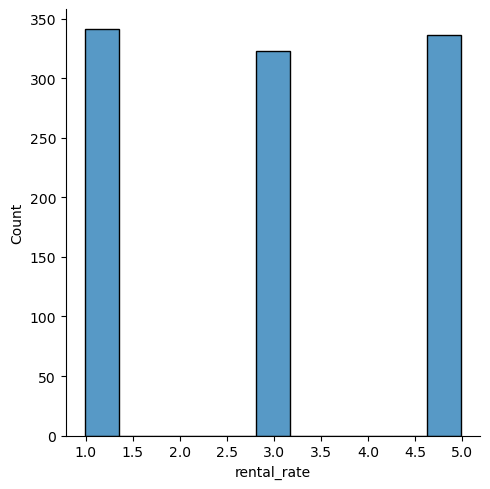

/Users/vschuckar/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


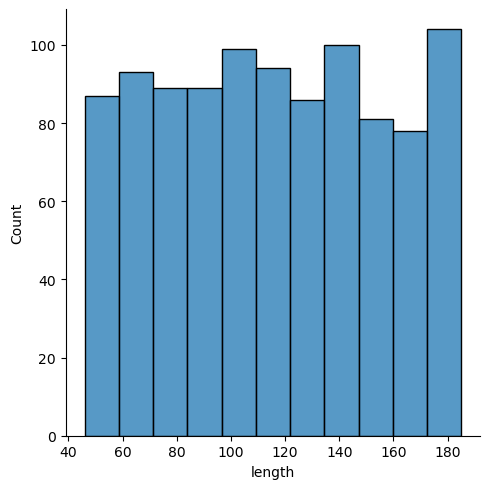

In [10]:
plot_distributions(data_x)

In [11]:
data_x['length'].skew() # not high so I will go straight to the minmax scaler and not do distribution

0.03332116668451906

In [12]:
data_x['rental_rate'] = data_x['rental_rate'].astype('object') # I will treat rental_rate as categorical since it only has 3 values 

In [13]:
data_x['rental_rate'].value_counts()

rental_rate
0.99    341
4.99    336
2.99    323
Name: count, dtype: int64

In [14]:
data = pd.merge(data_x, data_y, on = 'title', how = 'inner')
data.head()

,title,rating,rental_rate,length,category,rented_in_may
0,ACADEMY DINOSAUR,PG,0.99,86,Documentary,yes
1,ACE GOLDFINGER,G,4.99,48,Horror,no
2,ADAPTATION HOLES,NC-17,2.99,50,Documentary,yes
3,AFFAIR PREJUDICE,G,2.99,117,Horror,yes
4,AFRICAN EGG,G,2.99,130,Family,yes


In [15]:
data.dtypes

title            object
rating           object
rental_rate      object
length            int64
category         object
rented_in_may    object
dtype: object

In [16]:
y = data['rented_in_may']
X = data.drop(['rented_in_may', 'title'], axis = 1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5)

In [17]:
from sklearn.preprocessing import MinMaxScaler

X_train_num = X_train.select_dtypes(include = np.number) 
X_test_num  = X_test.select_dtypes(include = np.number)

transformer = MinMaxScaler().fit(X_train_num) 

X_train_normalized = transformer.transform(X_train_num)
X_test_normalized  = transformer.transform(X_test_num)

X_train_norm = pd.DataFrame(X_train_normalized, columns = X_train_num.columns, index = X_train_num.index)
X_test_norm  = pd.DataFrame(X_test_normalized, columns = X_test_num.columns, index = X_test_num.index)

In [18]:
from sklearn.preprocessing import OneHotEncoder

X_train_categorical = X_train.select_dtypes('object')
X_test_categorical  = X_test.select_dtypes('object')

encoder = OneHotEncoder(drop = 'first') 
encoder.fit(X_train_categorical)

X_train_cat_np = encoder.transform(X_train_categorical).toarray()
X_test_cat_np  = encoder.transform(X_test_categorical).toarray()

X_train_cat = pd.DataFrame(X_train_cat_np, columns = encoder.get_feature_names_out(), 
                           index = X_train_categorical.index)
X_test_cat  = pd.DataFrame(X_test_cat_np,  columns = encoder.get_feature_names_out(),
                          index = X_test_categorical.index)
display(X_train_cat)

,rating_NC-17,rating_PG,rating_PG-13,rating_R,rental_rate_2.99,rental_rate_4.99,category_Animation,category_Children,category_Classics,category_Comedy,...,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel
40,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
977,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
829,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
973,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
874,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
701,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
206,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
X_train_transformed = pd.concat([X_train_norm, X_train_cat], axis = 1)

In [20]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state = 0, solver = 'saga',
                  multi_class = 'multinomial')

classification.fit(X_train_transformed, y_train)

LogisticRegression(multi_class='multinomial', random_state=0, solver='saga')

In [ ]:
#fig, ax = plt.subplots()
#regression_line = lm.intercept_ + lm.coef_[0]*reg_data['AVGGIFT'] # b_0 + b_1 * x
#ax.plot(reg_data['AVGGIFT'], regression_line, c = 'orange') # the line in the plot
#sns.scatterplot(data=reg_data, x='AVGGIFT',y='TARGET_D', ax=ax)
#plt.show()

In [21]:
X_test_transformed = pd.concat([X_test_norm, X_test_cat], axis = 1)

In [22]:
# 5. Create a logistic regression model to predict 'rented_in_may' from the cleaned data.

from sklearn.metrics import accuracy_score
y_test_pred = classification.predict(X_test_transformed)

print(accuracy_score(y_test,y_test_pred))
classification.score(X_test_transformed, y_test)

0.675


0.675

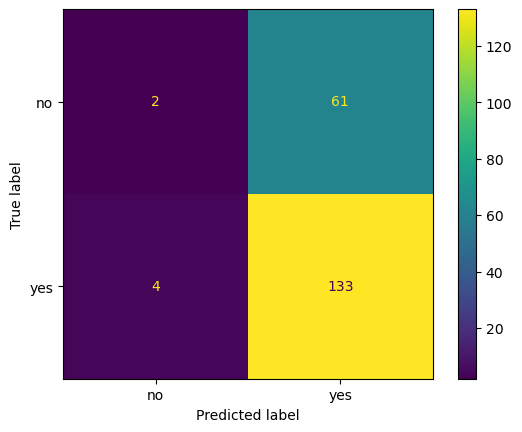

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix(y_test, y_test_pred)

cm_test = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(cm_test,display_labels = classification.classes_)
disp.plot()
plt.show()

In [24]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_test, y_test_pred) # disaster due to class imbalance 

0.003373198405397071

In [25]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

          no       0.33      0.03      0.06        63
         yes       0.69      0.97      0.80       137

    accuracy                           0.68       200
   macro avg       0.51      0.50      0.43       200
weighted avg       0.57      0.68      0.57       200



In [26]:
pd.Series(y_test_pred).value_counts() # very high class imbalance

yes    194
no       6
Name: count, dtype: int64

In [ ]:
# 6. Evaluate the results.

# considering 200 values used in the prediction, 32.5% were predicted wrong. 
# Accuracy: 0.675 -> not so low because it was easier to the model to classified it as 'yes' then 'no', not suitable 
# to judge this set of data due to the class imbalance. 
# Precision: same logic as above.
# Recall: same logic as above, very high because it could find most of the positive samples.
# f1-score: f1 is a good metric for class imbalance, since it balances precision and recall. 
# Kappa score: Extremely low in this case due to class imbalance. Values for this should be above 0.65 for the model to be valid.

# Solutions here: -  Use more features for the predict model from the sakila database. 
#                 - Use different approaches to balance the class distribution. 